In [1]:
!pip install argparse numpy pygame
!git clone 'https://github.com/Maluuba/jumping-task.git'
!pip install -e jumping-task/gym-jumping-task/

^C


Cloning into 'jumping-task.git''...
fatal: protocol ''https' is not supported
ERROR: jumping-task/gym-jumping-task/ is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [92]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Grayscale, ToPILImage

# Auxiliary Python imports
from scipy import spatial
import numpy as np
import pickle as pkl
import bz2
from tqdm.notebook import tqdm
from matplotlib import pylab as P, pyplot as plt
from matplotlib import colors
from collections import namedtuple

import umap
import umap.plot

## Gym imports
import gym
import gym_jumping_task

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rendering = not torch.cuda.is_available()
print(device)

cpu


## Auxiliary Functions

In [94]:
DEFAULT_SEED = np.sum([ord(c) for c in "Generalization"])
def reset_rng(seed = None):
    if seed is None:
        seed = DEFAULT_SEED
    np.random.seed(seed)
    torch.manual_seed(seed)

In [95]:
def plot(data, xlab="", ylab="", title="", markers=None, window=50):
    def moving_average_std():
        means = np.zeros(len(data))
        stds = np.zeros(len(data))
        for i in range(len(data)):
            window_data = data[max(0, i - window) : min(len(data)-1, i)+1]
            means[i] = np.mean(window_data)
            stds[i] = np.std(window_data)
        return means, stds
    
    
    means, stds = moving_average_std()
    plt.fill_between(np.arange(len(data)), means - stds, means + stds, color='g', alpha=0.2)
    plt.plot(means)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    plt.plot(data, alpha=0.3, c='r')
    
    if markers is not None:
        pos, info = markers
        pos = np.array(pos)
        if type(info) is str:
            if info == "vline":
                plt.vlines(pos, ymin=np.amin(data), ymax=np.amax(data), colors='black', alpha=0.5)
        else:
            plt.plot(pos[:, 0], pos[:, 1], marker='o', linestyle='None')
            for i in range(len(info)):
                plt.annotate(info[i], pos[i], xytext=(-5,5), textcoords='offset pixels')
    
    plt.show()

In [158]:
def plot_mean_std(xdata, ydata, xlab="", ylab="", title="", markers=None, window=50):
    
    means = np.zeros(len(xdata))
    stds = np.zeros_like(means)
    
    for i, x in enumerate(xdata):
        means[i] = np.mean(ydata[i])
        stds[i] = np.std(ydata[i])
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    plt.fill_between(xdata, means - stds, means + stds, color='g', alpha=0.2)
    plt.plot(xdata,means)
    #plt.plot(xdata, data, alpha=0.3, c='r')
    
    if markers is not None:
        pos, info = markers
        pos = np.array(pos)
        if type(info) is str:
            if info == "vline":
                plt.vlines(pos, ymin=np.amin(data), ymax=np.amax(data), colors='black', alpha=0.5)
        else:
            plt.plot(pos[:, 0], pos[:, 1], marker='o', linestyle='None')
            for i in range(len(info)):
                plt.annotate(info[i], pos[i], xytext=(-5,5), textcoords='offset pixels')
    
    plt.show()

In [159]:
def plot_results(results, training_settings, export_path=None):
    #plt.imshow(results)
    #cmap = colors.LinearSegmentedColormap.from_list("Custom",['#333333','#FAEADC'], N=100)
    plt.figure(figsize=(RANGE_OBSTACLE_POSITION/2,RANGE_FLOOR_HEIGHT/2))
    plt.pcolor(results[::-1],cmap='gray',edgecolors='#fc9f5d', linewidths=0.5, vmin=0, vmax=1.0)
    plt.colorbar()
    for t in training_settings:
        plt.annotate('T', (t['obstacle_position'] - OBSTACLE_MIN_POSITION, t['floor_height']), color='r', textcoords="offset points", xytext=(10, 10), fontsize='large', fontweight='bold', ha='center')
    plt.xlabel("Obstacle Position")
    plt.ylabel("Floor Height")
    if export_path is None:
        plt.show()
    else:
        plt.savefig(export_path)

In [97]:
def restricted_random_settings(n_samples, offset, min_distance):
    settings = []
    rnds = []
    if type(offset) is int:
        offset = (offset,offset)
    
    available = [i for i in range(MAX_SAMPLES)]
    while len(rnds) < n_samples:
        n = available[np.random.randint(len(available))]
        candidate = [n % (RANGE_OBSTACLE_POSITION+1) + OBSTACLE_MIN_POSITION, n // (RANGE_OBSTACLE_POSITION+1)]
        
        if candidate[0] < OBSTACLE_MIN_POSITION + offset[0] or candidate[1] < offset[1] or candidate[0] > OBSTACLE_MAX_POSITION-offset[0] or candidate[1] > RANGE_FLOOR_HEIGHT-offset[1]:
            continue
        
        md = np.amin(np.sqrt(np.sum(np.square(np.array(rnds) - np.array(candidate)), axis=-1))) if len(rnds) else np.inf
        if md >= min_distance:
            available.remove(n)
            rnds.append(candidate)
        
    for r in rnds:
        settings.append({
            'floor_height': r[1],
            'obstacle_position': r[0]
        })
    return settings

In [98]:
def sample_demonstrations(args_per_episodes, buffer = None, augement_reward_func=None, sample_zero_rewards=True, silent=False):
    env = gym_jumping_task.envs.JumpTaskEnv()
    expert = Expert(env)
    if buffer is None:
        buffer = ReplayBuffer()
    n_episodes = len(args_per_episodes)
    pbar = range(n_episodes)
    if not silent:
        pbar=tqdm(pbar)
    
    for e in pbar:
        episode = []
        args = args_per_episodes[e]
        state = env._reset(**args)
        done = False
        while not done:
            action = expert.select_action()
            next_state, reward, done, _ = env.step(action)
            if augement_reward_func is not None:
                reward = augement_reward_func(env,reward,action)
            
            if reward != 0 or sample_zero_rewards:
                episode.append(Transition(state, action, reward, next_state, done))
            state = next_state
        if reward == -1:
            print("[WARN] GAME LOST")
        buffer.add_episode(episode)
    env.close()
    if not silent:
        print("Transitions:", len(buffer))
    return buffer

## Testing the environment

In [99]:
gym.make('jumping-task-v0')
env = gym_jumping_task.envs.JumpTaskEnv()
ACTION_SPACE = env.nb_actions
STATE_SIZE = np.prod(env.state_shape)
floor_height = 10
obstacle_pos = 30
state = env._reset(floor_height=floor_height, obstacle_position=obstacle_pos)

c:\Users\sarrg\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (60, 60)
  logger.warn(


In [100]:
print(STATE_SIZE)

3600


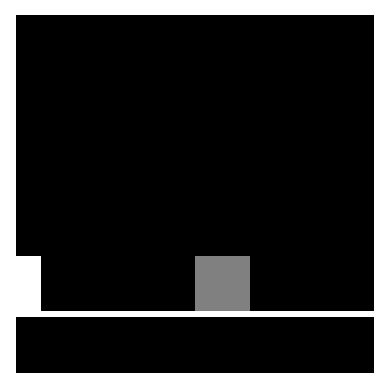

In [101]:
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')

## Define Expert policy

In [102]:
class Expert():
    def __init__(self, env: gym_jumping_task.envs.JumpTaskEnv):
        self.env = env
    
    def select_action(self, state=None):
        if self.env.agent_pos_x + 14 == self.env.obstacle_position:
            return 1
        return 0

Score: 57
Game Won


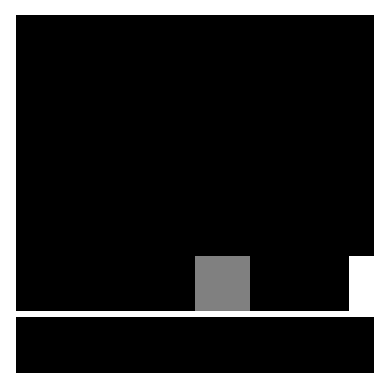

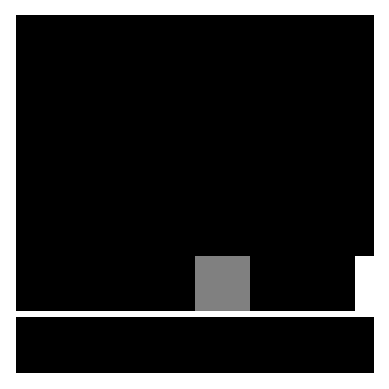

In [103]:
state = env.reset()
expert = Expert(env)
done = False
score = 0
prev_state = None
while not done:
    prev_state = state
    a = expert.select_action()
    state, reward, done, _ = env.step(a)
    score += reward
print("Score:", score)
print("Game", "Won" if reward == 2 else "Lost")
plt.axis('off')
plt.imshow(prev_state, cmap='gray', origin='lower')
plt.show()
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')
plt.show()

## Generate and store demonstrations played by the expert

In [104]:
#Transition = namedtuple('Transition', ['state', 'action', 'rewards', 'next_state', 'done'])
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class Episode(object):
    def __init__(self):
        self.transitions = []
        
    def __len__(self):
        return len(self.transitions)
    
    def append(self, transition):
        self.transition.append(transition)
        
    def __getitem__(self, index):
        return self.transitions[index]


class ReplayBuffer(object):
    def __init__(self, capacity=0):
        self.buffer = []
        self._next = 0
        self.capacity = int(capacity)
    
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def add_episode(self, episode):
        if self.capacity != 0 and len(self) == self.capacity:
            for t in episode:
                self.buffer[self._next] = t
                self._next = (self._next+1)%self.capacity
        else:
            cap = len(episode) if self.capacity == 0 else min(len(episode), self.capacity - len(self))
            self.buffer.extend(episode[0:cap])
    
    def add(self, transition: Transition):
        if self.capacity != 0 and len(self) == self.capacity:
            self.buffer[self._next] = transition
            self._next = (self._next+1)%self.capacity
        else:
            self.buffer.append(transition)
        
    def clear(self):
        self._next=0
        self.buffer.clear()
        
    def save(self, path):
        with bz2.open(path, "wb") as f:
            f.write(pkl.dumps(self.buffer))
    
    def load(self, path):
        with bz2.open(path, "rb") as f:
            self.buffer = pkl.loads(f.read())


In [105]:
n_episodes = 250

env = gym_jumping_task.envs.JumpTaskEnv()
expert = Expert(env)
buffer = ReplayBuffer()
for e in tqdm(range(n_episodes)):
    episode = []
    env.reset()
    done = False
    while not done:
        a = expert.select_action()
        next_state, reward, done, _ = env.step(a)
        episode.append(Transition(state, a, reward, next_state, done))
        state = next_state
    if reward == -1:
        print("[WARN] GAME LOST")
    buffer.add_episode(episode)
#buffer.save("demonstrations.bz2")
print("Transitions:", len(buffer))

  0%|          | 0/250 [00:00<?, ?it/s]

Transitions: 14000


## Create Dataset

In [106]:
class BufferDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        sample = self.buffer[index]
        state = torch.tensor(sample.state).unsqueeze(dim=0)
        next_state = torch.tensor(sample.next_state).unsqueeze(dim=0)
        reward = torch.tensor(sample.reward)
        _action = sample.action
        action = torch.zeros(ACTION_SPACE)
        action[_action] = 1.0
        done = torch.tensor(float(sample.done))
        return state.float().to(device), action.float().to(device), reward.float().to(device), next_state.float().to(device), done.float().to(device)

In [107]:
dataset = BufferDataset(buffer)
print(dataset.__getitem__(0))

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor([1., 0.]), tensor(1.), tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor(0.))


## Define Agent and Policy Network

In [108]:
class ActingNetwork(nn.Module):
    def __init__(self, num_actions, representation_size=128, dropout=0.0):
        super().__init__()

        self.num_actions = num_actions
        self.fc = nn.Sequential(
            nn.Linear(representation_size, representation_size//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(representation_size//4, num_actions),
        )

    def forward(self, x):
        x = self.fc(x)
        return x


In [109]:
class RepresentationNetwork(nn.Module):

    def __init__(self, num_actions, representation_size=128):
        super().__init__()

        self.num_actions = num_actions
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(8, 16, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=1),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256, representation_size),
            nn.ReLU(),
        )

    def forward(self, x):
        if len(x.size()) == 3:
            x = x.unsqueeze(dim=1)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [110]:
class Agent():
    def __init__(self, num_actions, representation_size=128, name = "Agent"):
        self.name = name
        self.representation_size = representation_size
        self.act_next_net = ActingNetwork(num_actions, representation_size, dropout=0.01).to(device)
        self.act_prev_net = ActingNetwork(num_actions, representation_size, dropout=0.25).to(device)
        self.representation_net = RepresentationNetwork(num_actions, representation_size).to(device)
        self.next_state_rep_net = RepresentationNetwork(num_actions, representation_size).to(device)
        self.optimizer = optim.Adam([*self.act_next_net.parameters(),*self.act_prev_net.parameters(), *self.representation_net.parameters(), *self.next_state_rep_net.parameters()], lr=1e-3)
    
    def eval(self):
        self.act_next_net.eval()
        self.act_prev_net.eval()
        self.representation_net.eval()
        self.next_state_rep_net.eval()
            
    def train(self):
        self.act_next_net.train()
        self.act_prev_net.train()
        self.representation_net.train()
        self.next_state_rep_net.train()
    
    def step(self, state, action, next_state, optimal=True):
        self.optimizer.zero_grad()
        rep = self.representation_net(state)
        next_state_rep = self.next_state_rep_net(next_state)
        
        prev_action = self.act_prev_net(next_state_rep)
        next_action = self.act_next_net(rep.detach())
        
        pair_type = torch.tensor(1.0 if optimal else 0.0)
        rep_loss = nn.functional.cosine_embedding_loss(rep, next_state_rep.detach(), target=pair_type * torch.ones(len(rep)), margin=0.1)
        #rep_loss_2 = nn.functional.cosine_embedding_loss(next_state_rep, torch.roll(next_state_rep.detach(), 1, dims=0), target=-torch.ones(len(rep)), margin=0.0)
        targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()
        act_loss = 0.2 * nn.functional.cross_entropy(prev_action, targets) + nn.functional.cross_entropy(next_action, action)
        loss = 0.5*(rep_loss) + act_loss
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    @staticmethod
    def transform(state):
        return torch.tensor(state).float().to(device).unsqueeze(0).unsqueeze(0)
    
    @torch.no_grad()
    def act(self, state):
        self.eval()
        state = self.transform(state)
        rep = self.representation_net(state)
        actions = self.act_next_net(rep).squeeze()
        return torch.argmax(actions).item()
    
    def save(self, info=None):
        if info is not None:
            info = '_' + info
        else:
            info = ''
        torch.save(self.model.state_dict(), f'models/{self.name}{info}.pth')
        
    def load(self, info=None):
        if info is not None:
            info = '_' + info
        else:
            info = ''
        self.model.load_state_dict(torch.load(f'models/{self.name}{info}.pth'))

## Training the Agent

In [111]:
class BCTrainer():
    """Behavioral Cloning Trainer class
    """
    
    def __init__(self, agent, dataloader, loss_func=None, optimizer=None, validation=False):
        self.agent = agent
        self.dataloader = dataloader
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.validation = validation
        
    def train(self, updates = None, pbar=None, show_progress=True):
        self.agent.train()
        if show_progress and pbar is None:
            pbar = tqdm(range(1))
        
        losses = []
        loader_len = len(self.dataloader)
        for i, (states, actions, _, next_states, _) in enumerate(self.dataloader):
            loss = self.agent.step(states, actions, next_states)

            losses.append(loss)
            if show_progress:
                pbar.set_postfix_str(f"[{i+1}/{loader_len}] Loss: {losses[-1]:.4f}")
            if updates is not None:
                updates -=1
                if updates == 0:
                    break
        return losses
    
    def eval(self, mode='dataset'):
        self.model.eval()
        
        if mode == 'dataset':
            losses = []
            loader_len = len(self.dataloader)
            for i, (states, actions, _, _, _) in enumerate(self.dataloader):
                pred = self.model(states)
                loss = self.loss_func(pred, actions)
                losses.append(loss.item())
            return losses
        
        if mode == 'all_episodes':
            _agent = Agent(self.model)
            _, winrate = evaluate_agent_on_all_episodes(_agent, verbose=False)
            return winrate
            
    def run(self, epochs, updates=None, show_progress=True):
        win_rates = None
        all_losses = []
        #all_losses.extend(self.eval())
        
        if self.validation:
            win_rates = np.zeros(epochs+1)
            win_rates[0] = self.eval(mode = 'all_episodes')
        
        pbar = range(1, epochs+1 if updates is None else updates+1)
        if show_progress:
            pbar = tqdm(pbar) 
        
        for e in pbar:
            losses = self.train(updates, pbar, show_progress)
            all_losses.extend(losses)
            if self.validation:
                win_rates[e] = self.eval(mode = 'all_episodes')
            
            if updates is not None:
                updates -= len(losses)
                if updates == 0:
                    break
        return all_losses, win_rates if self.validation else None

In [112]:
OBSTACLE_MAX_POSITION = 40-1
OBSTACLE_MIN_POSITION = 14
RANGE_OBSTACLE_POSITION = OBSTACLE_MAX_POSITION - OBSTACLE_MIN_POSITION
RANGE_FLOOR_HEIGHT = 10
MAX_SAMPLES = (RANGE_OBSTACLE_POSITION + 1) * (RANGE_FLOOR_HEIGHT + 1)
n_samples = 18

In [114]:
lr = 1e-3
batchsize = 64
n_epochs = 100
rep_size = 256

In [40]:
reset_rng()
rrand_sampling_settings = restricted_random_settings(n_samples, offset=(3,1), min_distance=2)


print(rrand_sampling_settings)

[{'floor_height': 3, 'obstacle_position': 23}, {'floor_height': 9, 'obstacle_position': 28}, {'floor_height': 1, 'obstacle_position': 32}, {'floor_height': 7, 'obstacle_position': 30}, {'floor_height': 3, 'obstacle_position': 26}, {'floor_height': 5, 'obstacle_position': 20}, {'floor_height': 8, 'obstacle_position': 18}, {'floor_height': 1, 'obstacle_position': 34}, {'floor_height': 6, 'obstacle_position': 34}, {'floor_height': 9, 'obstacle_position': 25}, {'floor_height': 9, 'obstacle_position': 31}, {'floor_height': 1, 'obstacle_position': 20}, {'floor_height': 2, 'obstacle_position': 36}, {'floor_height': 5, 'obstacle_position': 31}, {'floor_height': 1, 'obstacle_position': 18}, {'floor_height': 5, 'obstacle_position': 24}, {'floor_height': 1, 'obstacle_position': 29}, {'floor_height': 5, 'obstacle_position': 36}]


In [41]:
rrand_sampling_demonstrations = sample_demonstrations(rrand_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


In [42]:
reset_rng()

agent = Agent(ACTION_SPACE, rep_size)
#loss_func = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(net.parameters(), lr=lr)

loader = DataLoader(BufferDataset(rrand_sampling_demonstrations), batch_size=batchsize, shuffle=True)

trainer = BCTrainer(agent, loader)

In [43]:
losses, _ = trainer.run(n_epochs)


  0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\sarrg\AppData\Local\Temp\ipykernel_9336\1969981201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()


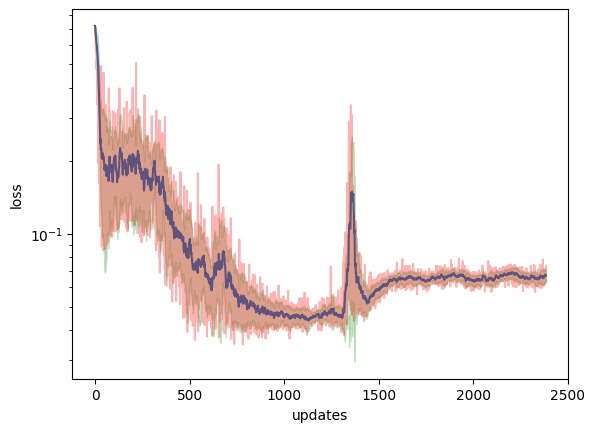

In [44]:
losses_per_epoch = len(losses) // (n_epochs + 1)

markers = []
markers = ([[losses_per_epoch*(i-1), losses[losses_per_epoch*i]] for i in range(1, n_epochs + 1)])
#markers.append([f"Ep{i}" for i in range(n_epochs)])
plt.yscale('log')
plot(losses[losses_per_epoch:], "updates", "loss", window=losses_per_epoch)

## Evaluation of Cause and Effect Representation Learning (CERL) Agent

In [161]:
def evaluate_agent(env, agent):
    state = env.get_state()
    done = False
    reward = 0
    while not done:
        a = agent.act(state)
        state, reward, done, _ = env.step(a)
    return reward == 2

In [162]:
def evaluate_on_random_episodes(env, agent, n_episodes=50):
    won = 0
    print(agent.name)
    with tqdm(range(n_episodes)) as pbar:
        for e in pbar:
            env.reset()
            won += int(evaluate_agent(env, agent))
            pbar.set_postfix_str(f"Won: {won}/{n_episodes}")
    env.close()
    return won / n_episodes

#### Evaluate on different seed

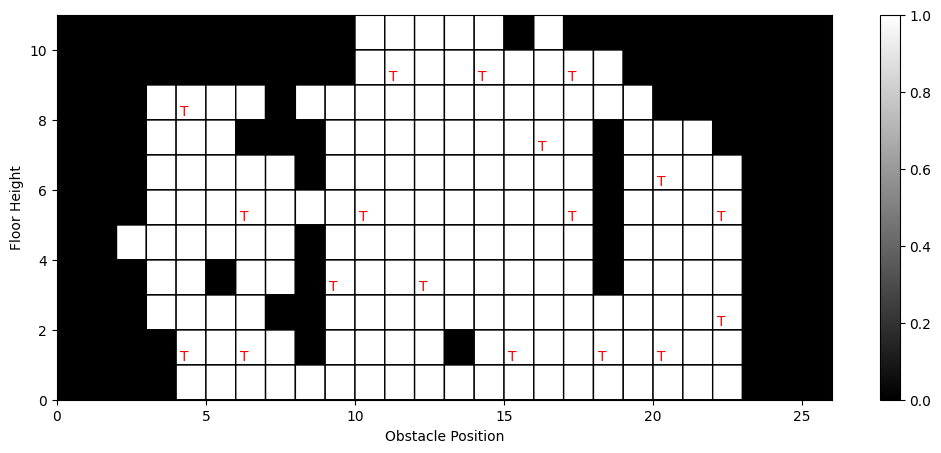

60.48951048951049


In [47]:
r, w = evaluate_agent_on_all_episodes(agent)
plot_results(r, rrand_sampling_settings)
print(w*100)

## UMAP

In [65]:
representations = []
metadata = []

frame_range = 5

for i, setting in enumerate(all_sample_settings):
    demonstrations = sample_demonstrations([setting], silent=True)
    jump_frame = np.argmax([d.action for d in demonstrations])
    loader = DataLoader(BufferDataset(demonstrations), batch_size=1, shuffle=False)
    first_jump = True
    for j, (state, action, _, next_state, _) in enumerate(loader):
        if j < jump_frame - frame_range or j > jump_frame + frame_range:
            continue
        
        rep = agent.representation_net(state).detach()
        pred_action = int(torch.argmax(agent.act_next_net(rep).detach()).squeeze().cpu().numpy())
        
        if first_jump and pred_action:
            first_jump = False
        else: 
            pred_action = 0
        rep = rep.squeeze().cpu().numpy()
        action = int(torch.argmax(action.detach()).squeeze().cpu().numpy())
        
        if action or pred_action or True:
            representations.append(rep)
            metadata.append([i, j - jump_frame, action, pred_action])
representations = np.array(representations)
metadata = np.array(metadata)

In [66]:
print(representations.shape)

(2981, 256)


In [67]:
reducer = umap.UMAP(random_state=DEFAULT_SEED, metric='cosine', n_neighbors=75)
reducer.fit(representations)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=75, random_state=1468, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

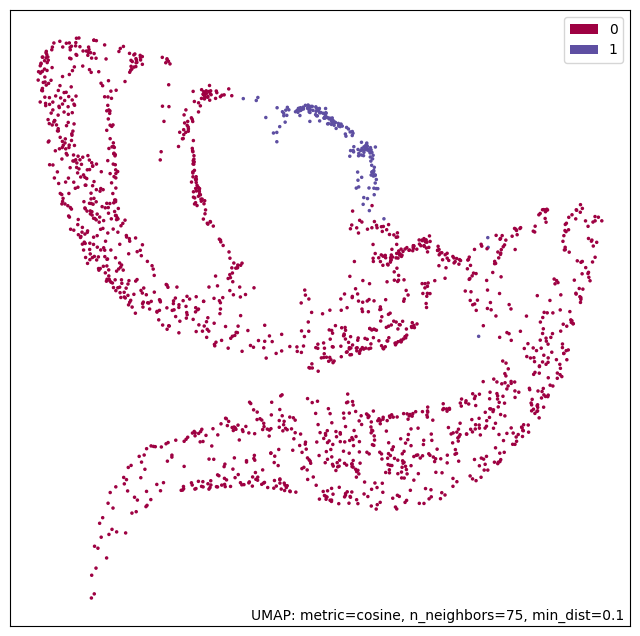

In [70]:
solved = np.array([i if t_a and t_a == p_a else -1 in rrand_sampling_settings for i, f, t_a, p_a in metadata])
explain = np.array([i in solved for i, f, t_a, p_a in metadata])
umap.plot.points(reducer, metadata[:, 2], cmap='inferno', subset_points=explain)

<Axes: >

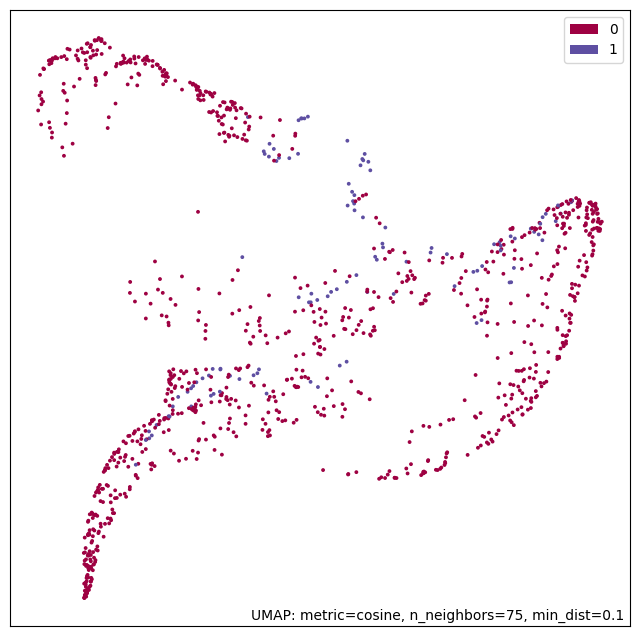

In [72]:
unsolved = np.array([i if t_a and t_a != p_a else -1 in rrand_sampling_settings for i, f, t_a, p_a in metadata])
explain = np.array([i in unsolved for i, f, t_a, p_a in metadata])
umap.plot.points(reducer, metadata[:, 2], cmap='inferno', subset_points=explain)

<Axes: >

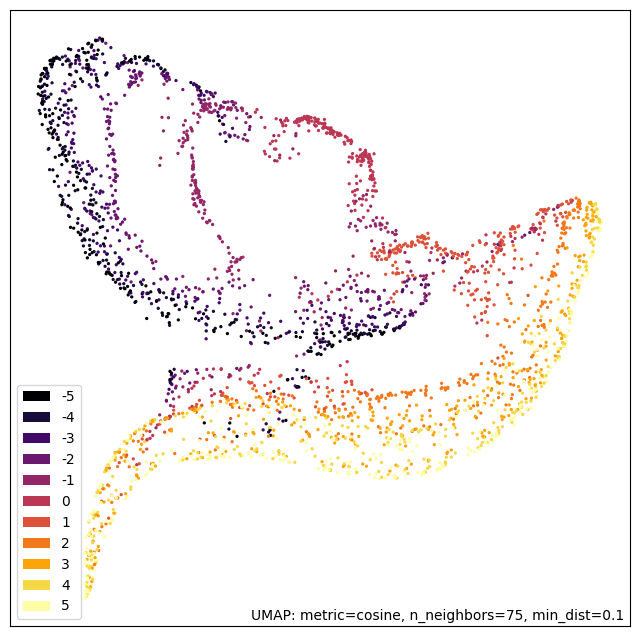

In [91]:
umap.plot.points(reducer, metadata[:, 1], color_key_cmap='inferno')

<Axes: >

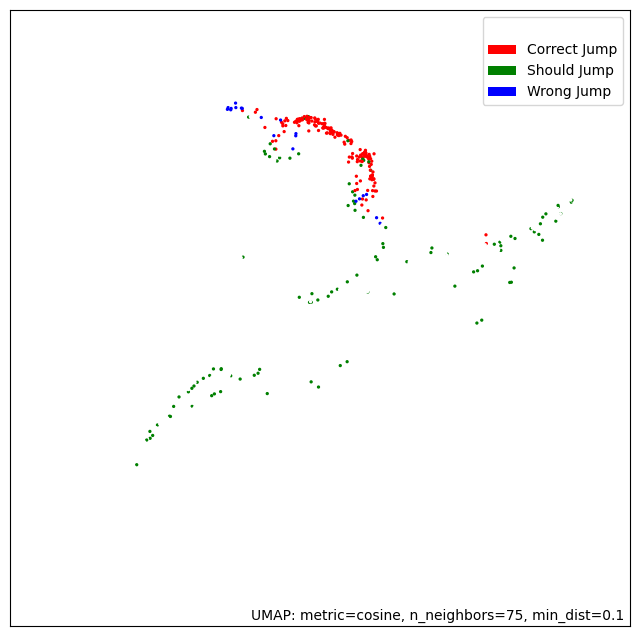

In [90]:
explain = ['Should Jump' if t_a and not p_a else ('Correct Jump' if t_a and p_a else ('Wrong Jump' if p_a and not t_a else "")) for i, f, t_a, p_a in metadata]

umap.plot.points(reducer, np.array(explain), color_key=['r', 'g', 'b'] if "" not in explain else ['white', 'r', 'g', 'b'])

## Testing with different Demonstration Samplings

In [117]:
OBSTACLE_MAX_POSITION = 40-1
OBSTACLE_MIN_POSITION = 14
RANGE_OBSTACLE_POSITION = OBSTACLE_MAX_POSITION - OBSTACLE_MIN_POSITION
RANGE_FLOOR_HEIGHT = 10
MAX_SAMPLES = (RANGE_OBSTACLE_POSITION + 1) * (RANGE_FLOOR_HEIGHT + 1)
n_samples = 18

In [118]:
lr = 1e-3
batchsize = 64
wd = 1e-5
n_epochs = 100
rep_size = 256

In [119]:
def evaluate_agent_on_all_episodes(agent, verbose = False):
    env = gym_jumping_task.envs.JumpTaskEnv(rendering=verbose, seed=8)
    results = np.zeros((RANGE_FLOOR_HEIGHT+1, RANGE_OBSTACLE_POSITION+1))
    
    pbar = None
    if verbose:
        print(agent.name)
        pbar = tqdm(total=MAX_SAMPLES)
    
    won = 0
    for floor_height in range(RANGE_FLOOR_HEIGHT+1):
        for obstacle_pos in range(OBSTACLE_MIN_POSITION, OBSTACLE_MAX_POSITION+1):
            env._reset(obstacle_position=obstacle_pos, floor_height=floor_height)
            result = int(evaluate_agent(env, agent))
            results[RANGE_FLOOR_HEIGHT - floor_height, obstacle_pos - OBSTACLE_MIN_POSITION] = result
            won += result
            if pbar is not None:
                pbar.set_postfix_str(f"Won: {won}/{MAX_SAMPLES}")
                pbar.update()
    env.close()
    return results, won / MAX_SAMPLES

In [129]:
def test_sampling_strategy(demonstrations: ReplayBuffer, agent_name="Agent", validation=False, silent=False, n_runs=1, updates=None, redo_fails=False, hyperparameters={}):
    
    dataset = BufferDataset(demonstrations)
    results = []

    pbar = range(n_runs)

    if not silent:
        pbar = tqdm(pbar)

    if n_runs > 10:
        silent = True

    def get_hp(hp_name, default):
        return hyperparameters[hp_name] if hp_name in hyperparameters else default

    _lr = get_hp('lr', lr)
    _batchsize = get_hp('batchsize', batchsize)
    _wd = get_hp('wd', wd)
    _n_epochs =  get_hp('n_epochs', n_epochs)
    seed = DEFAULT_SEED
    for i in pbar:
        
        done_run = False
        while not done_run:
            reset_rng(DEFAULT_SEED+i)

            _agent = Agent(ACTION_SPACE, rep_size, name="DESU")

            loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
                
            trainer = BCTrainer(_agent, loader, validation=validation and not silent)
    
            losses, win_rates = trainer.run(n_epochs, updates=updates, show_progress = not silent)

            result, _ = evaluate_agent_on_all_episodes(_agent, verbose=rendering and n_runs==1 and not silent)
            
            if not redo_fails or np.sum(result) > 0.0:
                results.append(result)
                done_run = True
            

    if not silent:
        plt.yscale('log')
        plot(losses, "updates", "loss (log scale)", window=len(loader))
    
    if not silent and win_rates is not None:
        plt.plot(win_rates)
        plt.show()
    results = np.stack(results, axis=0)
    return np.mean(results, axis=0), np.mean(results, axis=(1,2))


In [121]:
def sample_demonstrations(args_per_episodes, buffer = None, augement_reward_func=None, sample_zero_rewards=True, silent=False):
    env = gym_jumping_task.envs.JumpTaskEnv()
    expert = Expert(env)
    if buffer is None:
        buffer = ReplayBuffer()
    n_episodes = len(args_per_episodes)
    pbar = range(n_episodes)
    if not silent:
        pbar=tqdm(pbar)
    
    for e in pbar:
        episode = []
        args = args_per_episodes[e]
        state = env._reset(**args)
        done = False
        while not done:
            action = expert.select_action()
            next_state, reward, done, _ = env.step(action)
            if augement_reward_func is not None:
                reward = augement_reward_func(env,reward,action)
            
            if reward != 0 or sample_zero_rewards:
                episode.append(Transition(state, action, reward, next_state, done))
            state = next_state
        if reward == -1:
            print("[WARN] GAME LOST")
        buffer.add_episode(episode)
    env.close()
    if not silent:
        print("Transitions:", len(buffer))
    return buffer

In [122]:
def sample_settings(n_samples, offset = 0, spacing = 4, samples_per_row = 6):
    settings = []
    if type(offset) is int:
        offset = (offset, offset)
    
    if type(spacing) is int:
        spacing = (spacing, spacing)
        
    for floor_height in range(offset[1], RANGE_FLOOR_HEIGHT+1, spacing[1]+1):
        row_samples = 0
        for obstacle_pos in range(OBSTACLE_MIN_POSITION + offset[0], OBSTACLE_MAX_POSITION+1, spacing[0]+1):
            settings.append({
                'floor_height': RANGE_FLOOR_HEIGHT - floor_height,
                'obstacle_position': obstacle_pos
            })
            row_samples += 1
            if row_samples == samples_per_row:
                break
        if len(settings) == n_samples:
            break
    return settings

In [123]:
all_sample_settings = sample_settings(1000, 0, 0, 1000)
print(len(all_sample_settings))

286


### Wide Sampling
```
T * * T * * T
* * * * * * *
* * * * * * *
T * * T * * T
* * * * * * *
* * * * * * *
T * * T * * T
```

In [124]:
wide_sampling_settings = sample_settings(n_samples, offset=(0,0), spacing=(4,4), samples_per_row=6)
print(wide_sampling_settings)

[{'floor_height': 10, 'obstacle_position': 14}, {'floor_height': 10, 'obstacle_position': 19}, {'floor_height': 10, 'obstacle_position': 24}, {'floor_height': 10, 'obstacle_position': 29}, {'floor_height': 10, 'obstacle_position': 34}, {'floor_height': 10, 'obstacle_position': 39}, {'floor_height': 5, 'obstacle_position': 14}, {'floor_height': 5, 'obstacle_position': 19}, {'floor_height': 5, 'obstacle_position': 24}, {'floor_height': 5, 'obstacle_position': 29}, {'floor_height': 5, 'obstacle_position': 34}, {'floor_height': 5, 'obstacle_position': 39}, {'floor_height': 0, 'obstacle_position': 14}, {'floor_height': 0, 'obstacle_position': 19}, {'floor_height': 0, 'obstacle_position': 24}, {'floor_height': 0, 'obstacle_position': 29}, {'floor_height': 0, 'obstacle_position': 34}, {'floor_height': 0, 'obstacle_position': 39}]


In [125]:
wide_demonstrations = sample_demonstrations(wide_sampling_settings)


  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sarrg\AppData\Local\Temp\ipykernel_9336\1969981201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

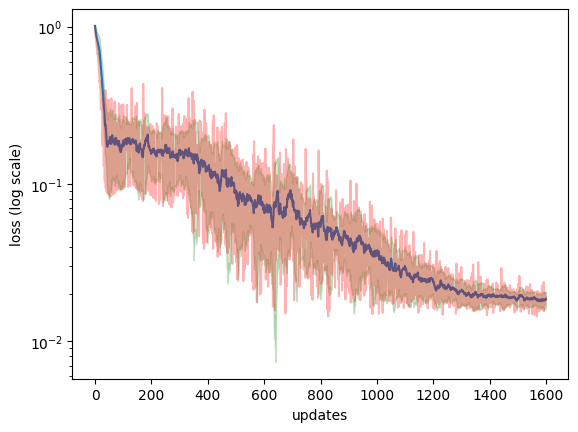

In [132]:
wide_results_per_sample, wide_results_per_run = test_sampling_strategy(wide_demonstrations, "Wide Agent", n_runs=5, redo_fails=True)

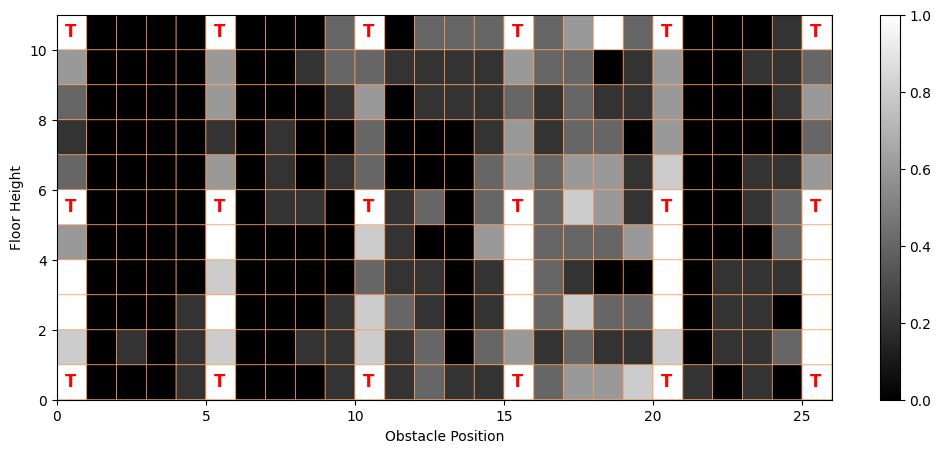

Estimated Winrate: 29.7% (+- 12.3%)


In [163]:
plot_results(wide_results_per_sample, wide_sampling_settings)
print(f"Estimated Winrate: {np.sum(wide_results_per_sample) / wide_results_per_sample.size *100:.1f}% (+- {np.std(wide_results_per_run)*100:.1f}%)")

### Narrow Sampling
```
* * * * * * *
* T * T * T *
* * * * * * *
* T * T * T *
* * * * * * *
* T * T * T *
* * * * * * *
```

In [134]:
narrow_sampling_settings = sample_settings(n_samples, offset=(8,3), spacing=1, samples_per_row=6)
print(narrow_sampling_settings)

[{'floor_height': 7, 'obstacle_position': 22}, {'floor_height': 7, 'obstacle_position': 24}, {'floor_height': 7, 'obstacle_position': 26}, {'floor_height': 7, 'obstacle_position': 28}, {'floor_height': 7, 'obstacle_position': 30}, {'floor_height': 7, 'obstacle_position': 32}, {'floor_height': 5, 'obstacle_position': 22}, {'floor_height': 5, 'obstacle_position': 24}, {'floor_height': 5, 'obstacle_position': 26}, {'floor_height': 5, 'obstacle_position': 28}, {'floor_height': 5, 'obstacle_position': 30}, {'floor_height': 5, 'obstacle_position': 32}, {'floor_height': 3, 'obstacle_position': 22}, {'floor_height': 3, 'obstacle_position': 24}, {'floor_height': 3, 'obstacle_position': 26}, {'floor_height': 3, 'obstacle_position': 28}, {'floor_height': 3, 'obstacle_position': 30}, {'floor_height': 3, 'obstacle_position': 32}]


In [135]:
narrow_sampling_demonstrations = sample_demonstrations(narrow_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sarrg\AppData\Local\Temp\ipykernel_9336\1969981201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

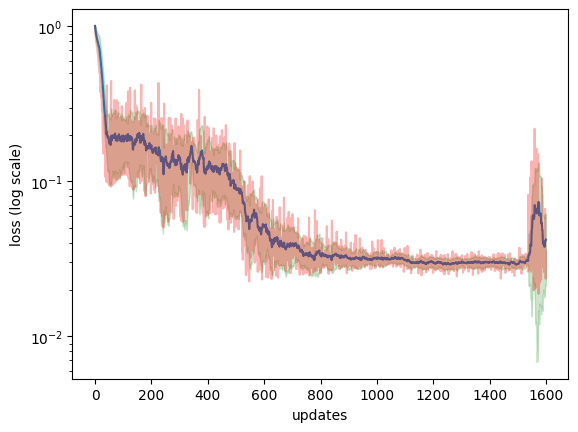

In [136]:
narrow_results_per_sample, narrow_results_per_run = test_sampling_strategy(narrow_sampling_demonstrations, "Narrow Agent", n_runs=5, redo_fails=True)

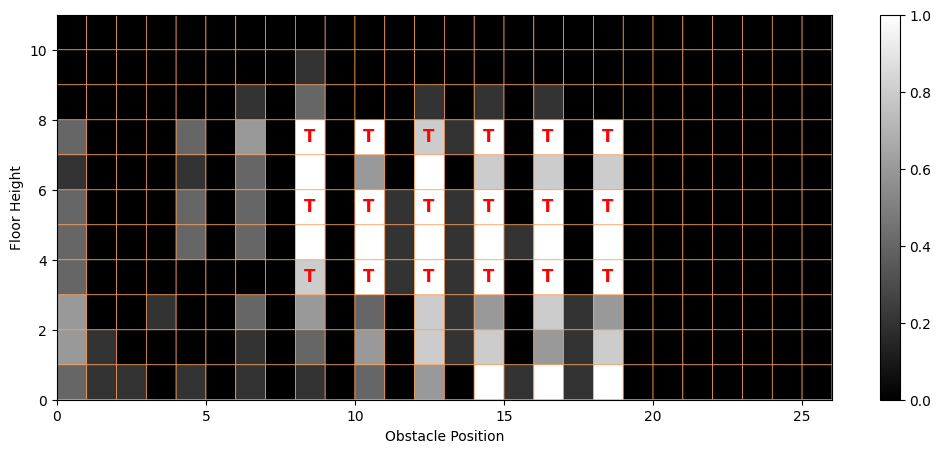

Estimated Winrate: 18.6% (+- 2.7%)


In [164]:
plot_results(narrow_results_per_sample, narrow_sampling_settings)
print(f"Estimated Winrate: {np.sum(narrow_results_per_run) / narrow_results_per_run.size *100:.1f}% (+- {np.std(narrow_results_per_run)*100:.1f}%)")

### Random Sampling
```
* T * * * T *
* * T * * * *
* * * * * * *
* T * T * * *
* * * * T * *
* * * * * T T
* * T * * * *
```

In [139]:
def random_settings(n_samples):
    settings = []
    rnds = np.random.choice(MAX_SAMPLES, size=n_samples, replace=False)
    for n in rnds:
        settings.append({
                'floor_height': n // (RANGE_OBSTACLE_POSITION+1),
                'obstacle_position': n % (RANGE_OBSTACLE_POSITION+1) + OBSTACLE_MIN_POSITION
        })
    return settings

In [141]:
reset_rng()
rnd_sampling_settings = random_settings(n_samples)
print(rnd_sampling_settings)

[{'floor_height': 5, 'obstacle_position': 15}, {'floor_height': 10, 'obstacle_position': 33}, {'floor_height': 10, 'obstacle_position': 18}, {'floor_height': 7, 'obstacle_position': 14}, {'floor_height': 4, 'obstacle_position': 29}, {'floor_height': 9, 'obstacle_position': 22}, {'floor_height': 6, 'obstacle_position': 27}, {'floor_height': 8, 'obstacle_position': 25}, {'floor_height': 5, 'obstacle_position': 38}, {'floor_height': 8, 'obstacle_position': 38}, {'floor_height': 4, 'obstacle_position': 24}, {'floor_height': 9, 'obstacle_position': 35}, {'floor_height': 10, 'obstacle_position': 23}, {'floor_height': 1, 'obstacle_position': 16}, {'floor_height': 3, 'obstacle_position': 36}, {'floor_height': 3, 'obstacle_position': 20}, {'floor_height': 9, 'obstacle_position': 19}, {'floor_height': 1, 'obstacle_position': 21}]


In [142]:
rnd_sampling_demonstrations = sample_demonstrations(rnd_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sarrg\AppData\Local\Temp\ipykernel_9336\1969981201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

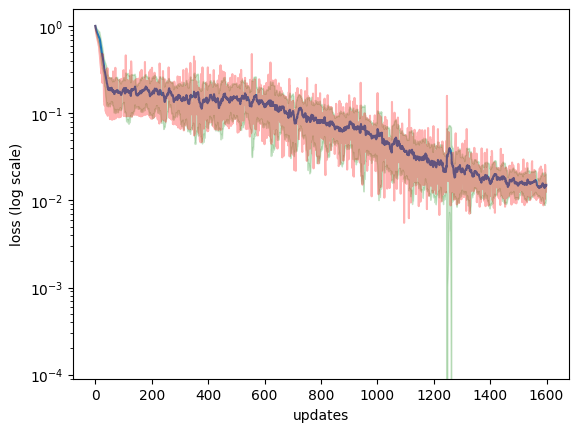

In [143]:
rnd_results_per_sample, rnd_results_per_run = test_sampling_strategy(rnd_sampling_demonstrations, "Random Sampling Agent", validation=False, n_runs=5, redo_fails=True)

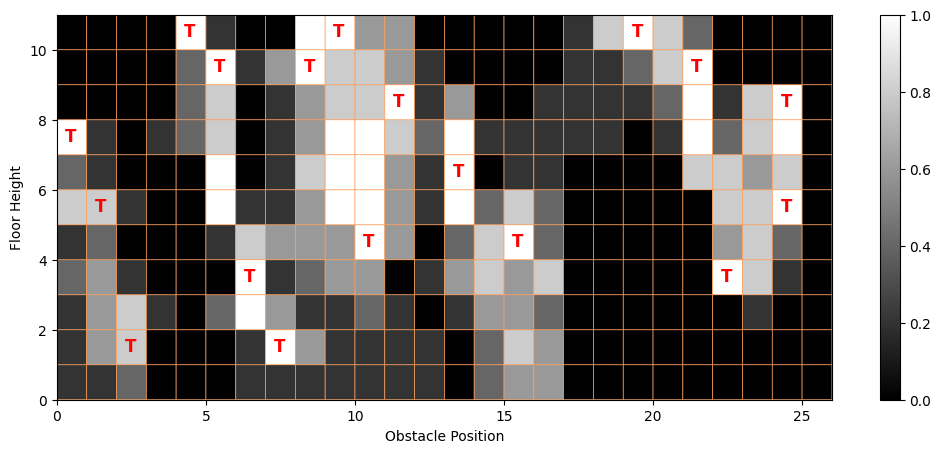

Estimated Winrate: 32.9% (+- 5.2%)


In [167]:
plot_results(rnd_results_per_sample, rnd_sampling_settings)
print(f"Estimated Winrate: {np.sum(rnd_results_per_run) / rnd_results_per_run.size *100:.1f}% (+- {np.std(rnd_results_per_run)*100:.1f}%)")

### Mixed Sampling (Narrow and Wide)

In [147]:
mixed_sampling_settings = []
adj_nss = sample_settings(n_samples, offset=(3,3), spacing=1, samples_per_row=6)
adj_nss = sample_settings(n_samples, offset=(5,2), spacing=2, samples_per_row=6)
for n in range(0, len(wide_sampling_settings), 6):
    if (n // 6 % 2) == 0:
        mixed_sampling_settings.extend(wide_sampling_settings[n:n+6])
    else:
        #mixed_sampling_settings.extend(narrow_sampling_settings[n:n+6])
        mixed_sampling_settings.extend(adj_nss[n:n+6])
print(mixed_sampling_settings)

[{'floor_height': 10, 'obstacle_position': 14}, {'floor_height': 10, 'obstacle_position': 19}, {'floor_height': 10, 'obstacle_position': 24}, {'floor_height': 10, 'obstacle_position': 29}, {'floor_height': 10, 'obstacle_position': 34}, {'floor_height': 10, 'obstacle_position': 39}, {'floor_height': 5, 'obstacle_position': 19}, {'floor_height': 5, 'obstacle_position': 22}, {'floor_height': 5, 'obstacle_position': 25}, {'floor_height': 5, 'obstacle_position': 28}, {'floor_height': 5, 'obstacle_position': 31}, {'floor_height': 5, 'obstacle_position': 34}, {'floor_height': 0, 'obstacle_position': 14}, {'floor_height': 0, 'obstacle_position': 19}, {'floor_height': 0, 'obstacle_position': 24}, {'floor_height': 0, 'obstacle_position': 29}, {'floor_height': 0, 'obstacle_position': 34}, {'floor_height': 0, 'obstacle_position': 39}]


In [148]:
mixed_sampling_demonstrations = sample_demonstrations(mixed_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sarrg\AppData\Local\Temp\ipykernel_9336\1969981201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

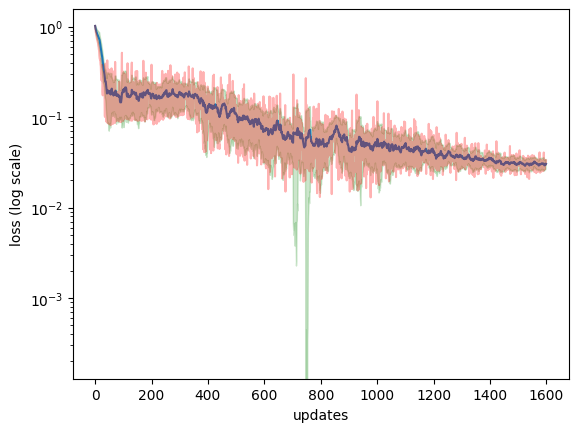

In [149]:
mixed_results_per_sample, mixed_results_per_run = test_sampling_strategy(mixed_sampling_demonstrations, "Mixed Sampling Agent", validation=False, n_runs=5, redo_fails=True)

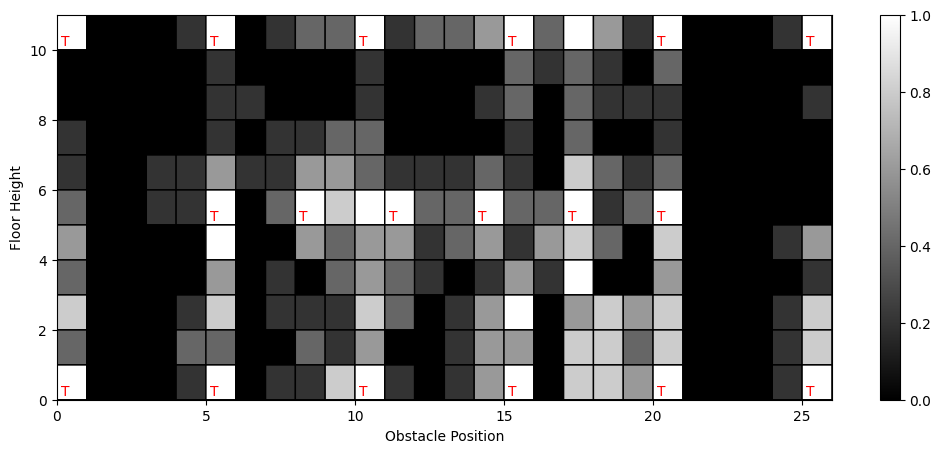

Estimated Winrate: 27.0% (+- 8.4%)


In [151]:
plot_results(mixed_results_per_sample, mixed_sampling_settings)
print(f"Estimated Winrate: {np.sum(mixed_results_per_run) / mixed_results_per_run.size *100:.1f}% (+- {np.std(mixed_results_per_run)*100:.1f}%)")

# Optimized Random Sampling
Instead of allowing any environment to be samples from, let us restrict that they are not allowed on to be on the highest and lowest floor heighest or lowest obstacle position, and not closer than 1.5 radius distance to other samples.

In [152]:
def optimized_random_settings(n_samples, offset, min_distance):
    settings = []
    rnds = []
    if type(offset) is int:
        offset = (offset,offset)
    
    available = [i for i in range(MAX_SAMPLES)]
    while len(rnds) < n_samples:
        n = available[np.random.randint(len(available))]
        candidate = [n % (RANGE_OBSTACLE_POSITION+1) + OBSTACLE_MIN_POSITION, n // (RANGE_OBSTACLE_POSITION+1)]
        
        if candidate[0] < OBSTACLE_MIN_POSITION + offset[0] or candidate[1] < offset[1] or candidate[0] > OBSTACLE_MAX_POSITION-offset[0] or candidate[1] > RANGE_FLOOR_HEIGHT-offset[1]:
            continue
        
        md = np.amin(np.sqrt(np.sum(np.square(np.array(rnds) - np.array(candidate)), axis=-1))) if len(rnds) else np.inf
        if md >= min_distance:
            available.remove(n)
            rnds.append(candidate)
        
    for r in rnds:
        settings.append({
            'floor_height': r[1],
            'obstacle_position': r[0]
        })
    return settings

In [169]:
optimized_sampling_settings = optimized_random_settings(n_samples, offset=(3,1), min_distance=2)
reset_rng()

print(optimized_sampling_settings)

[{'floor_height': 3, 'obstacle_position': 23}, {'floor_height': 9, 'obstacle_position': 28}, {'floor_height': 1, 'obstacle_position': 32}, {'floor_height': 7, 'obstacle_position': 30}, {'floor_height': 3, 'obstacle_position': 26}, {'floor_height': 5, 'obstacle_position': 20}, {'floor_height': 8, 'obstacle_position': 18}, {'floor_height': 1, 'obstacle_position': 34}, {'floor_height': 6, 'obstacle_position': 34}, {'floor_height': 9, 'obstacle_position': 25}, {'floor_height': 9, 'obstacle_position': 31}, {'floor_height': 1, 'obstacle_position': 20}, {'floor_height': 2, 'obstacle_position': 36}, {'floor_height': 5, 'obstacle_position': 31}, {'floor_height': 1, 'obstacle_position': 18}, {'floor_height': 5, 'obstacle_position': 24}, {'floor_height': 1, 'obstacle_position': 29}, {'floor_height': 5, 'obstacle_position': 36}]


In [170]:
optimized_sampling_demonstrations = sample_demonstrations(optimized_sampling_settings)

  0%|          | 0/18 [00:00<?, ?it/s]

Transitions: 1008


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\sarrg\AppData\Local\Temp\ipykernel_9336\1969981201.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(action if optimal else torch.abs(action - 1.0)).float()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

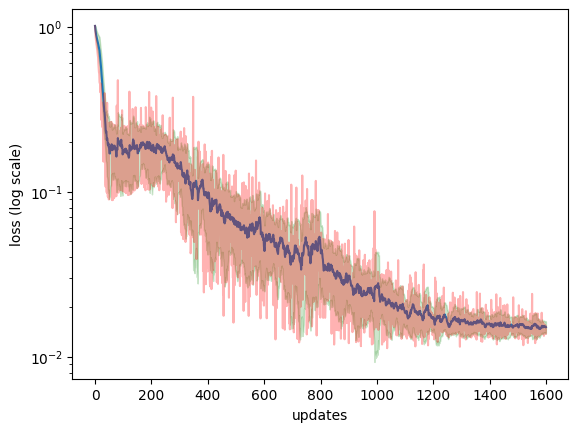

In [155]:
optimized_results_per_sample, optimized_results_per_run = test_sampling_strategy(optimized_sampling_demonstrations, "Optimized Random Sampling Agent", validation=False, n_runs=5, redo_fails=True)

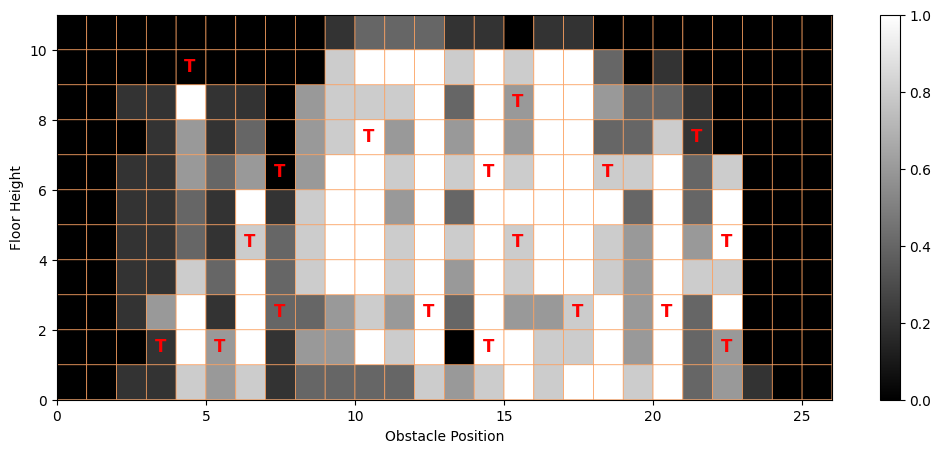

Estimated Winrate: 47.8% (+- 9.6%)


In [160]:
plot_results(optimized_results_per_sample, optimized_sampling_settings)
print(f"Estimated Winrate: {np.sum(optimized_results_per_run) / optimized_results_per_run.size *100:.1f}% (+- {np.std(optimized_results_per_run)*100:.1f}%)")